# Challenge: Factors that affect life expectancy

Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which 
factors decrease it.

In [64]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from sklearn.preprocessing import normalize

from math import ceil

import matplotlib.pyplot as plt

import seaborn as sns
from sqlalchemy import create_engine
import warnings
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [65]:
# read in us education data 

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_exp = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [66]:
# clean column labels

find_rep = {' ': '_',
            '/': '_'}

for item in find_rep:
    life_exp.columns = life_exp.columns.str.replace(item, find_rep[item])

life_exp.columns = map(str.lower, life_exp.columns)

In [67]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [68]:
life_exp.shape

(2938, 22)

In [69]:
life_exp.dtypes

country                             object
year                                 int64
status                              object
life_expectancy_                   float64
adult_mortality                    float64
infant_deaths                        int64
alcohol                            float64
percentage_expenditure             float64
hepatitis_b                        float64
measles_                             int64
_bmi_                              float64
under-five_deaths_                   int64
polio                              float64
total_expenditure                  float64
diphtheria_                        float64
_hiv_aids                          float64
gdp                                float64
population                         float64
_thinness__1-19_years              float64
_thinness_5-9_years                float64
income_composition_of_resources    float64
schooling                          float64
dtype: object

### 1. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

#### Deal with nan values

In [72]:
# how many nan values are there for each column?
life_exp.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy_                    10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles_                             0
_bmi_                               34
under-five_deaths_                   0
polio                               19
total_expenditure                  226
diphtheria_                         19
_hiv_aids                            0
gdp                                448
population                         652
_thinness__1-19_years               34
_thinness_5-9_years                 34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [73]:
# for each country, interpolate to fill na values
# since this is time series data 
# my guess is that most trends will change 
# in the same direction for all countries.

for col in life_exp.columns[3:]:
    for country in life_exp.country.unique():
        life_exp.loc[life_exp['country'] == country, col] = \
        life_exp.loc[life_exp['country'] == country, col].fillna(
        life_exp.loc[life_exp['country'] == country, col].interpolate())

In [74]:
# verify nan values are filled
# I'm still left with a large number of nan values
# should I just drop these?
life_exp.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy_                    10
adult_mortality                     10
infant_deaths                        0
alcohol                            192
percentage_expenditure               0
hepatitis_b                        144
measles_                             0
_bmi_                               34
under-five_deaths_                   0
polio                                0
total_expenditure                  210
diphtheria_                          0
_hiv_aids                            0
gdp                                422
population                         652
_thinness__1-19_years               34
_thinness_5-9_years                 34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [75]:
# because I still have so many NaN values
# fill nan values for the entire column using interpolate
# instead of by column and country

for col in life_exp.columns[3:]:
    life_exp.loc[:, col] = \
    life_exp.loc[:, col].fillna(
    life_exp.loc[:, col].interpolate())

In [76]:
# how many nan values are there for each column?
# this method removed all nan values
# but probably isn't as effective as the first method?
life_exp.isna().sum()

country                            0
year                               0
status                             0
life_expectancy_                   0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles_                           0
_bmi_                              0
under-five_deaths_                 0
polio                              0
total_expenditure                  0
diphtheria_                        0
_hiv_aids                          0
gdp                                0
population                         0
_thinness__1-19_years              0
_thinness_5-9_years                0
income_composition_of_resources    0
schooling                          0
dtype: int64

#### Deal with outlier values

In [77]:
# identify columns that have at least one
# data point that lies outside the 99.7th percentile (3 standard deviations)
# for that column
columns_with_outliers = []

for column in life_exp.columns[3:]:
    if len(np.where(zscore(life_exp[column]) > 3)[0]) > 1:
        columns_with_outliers.append(column)
        print(column)
        print(len(np.where(zscore(life_exp[column]) > 3)[0]))

adult_mortality
40
infant_deaths
37
alcohol
4
percentage_expenditure
84
measles_
48
under-five_deaths_
34
total_expenditure
26
_hiv_aids
69
gdp
87
population
22
_thinness__1-19_years
53
_thinness_5-9_years
55


There are a lot of outliers beyond 3 standard deviations.  These seem to mostly be columns that don't have normal distributions.

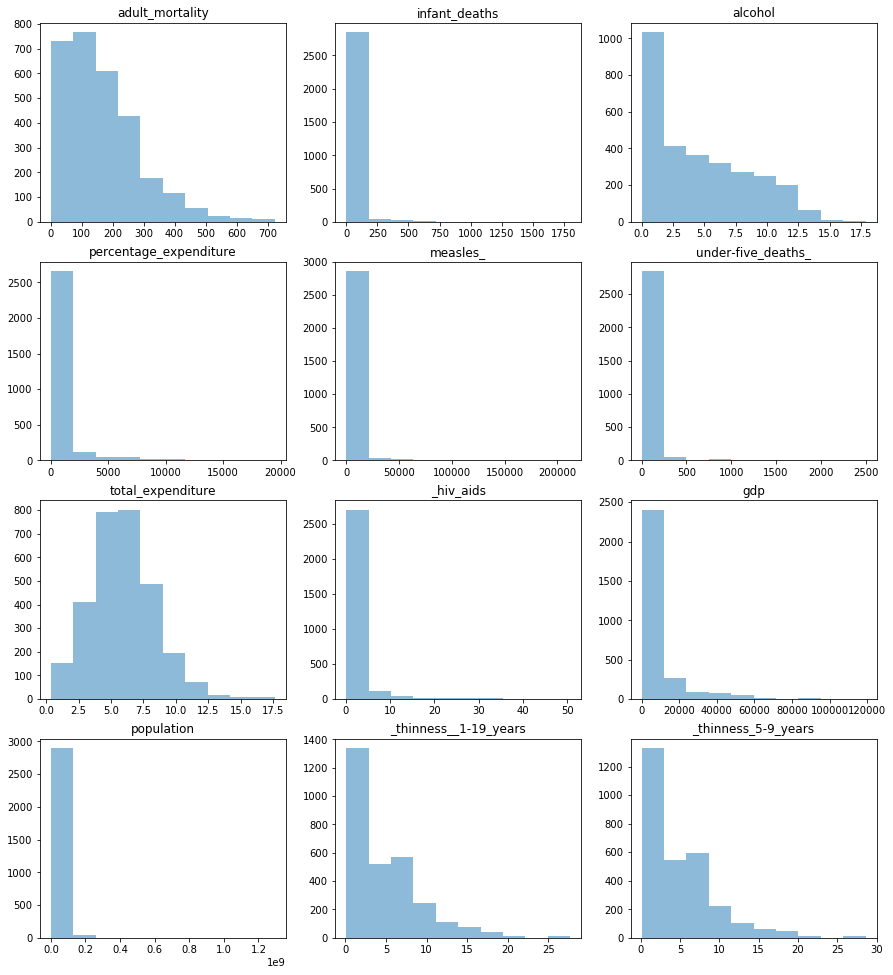

In [78]:
# show histogram for each outlier column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(columns_with_outliers):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

## I may want to do boxcox farther down so that I can do ananlysis near that top using meaningful numbers, such as mean life expectancy for each country.

In [79]:
# apply box cox to all variables
# but to be able to do this I need all variables to be positive

for column in life_exp.columns[3:]:
    life_exp[column],_ = boxcox(life_exp.loc[:,column] + 1)


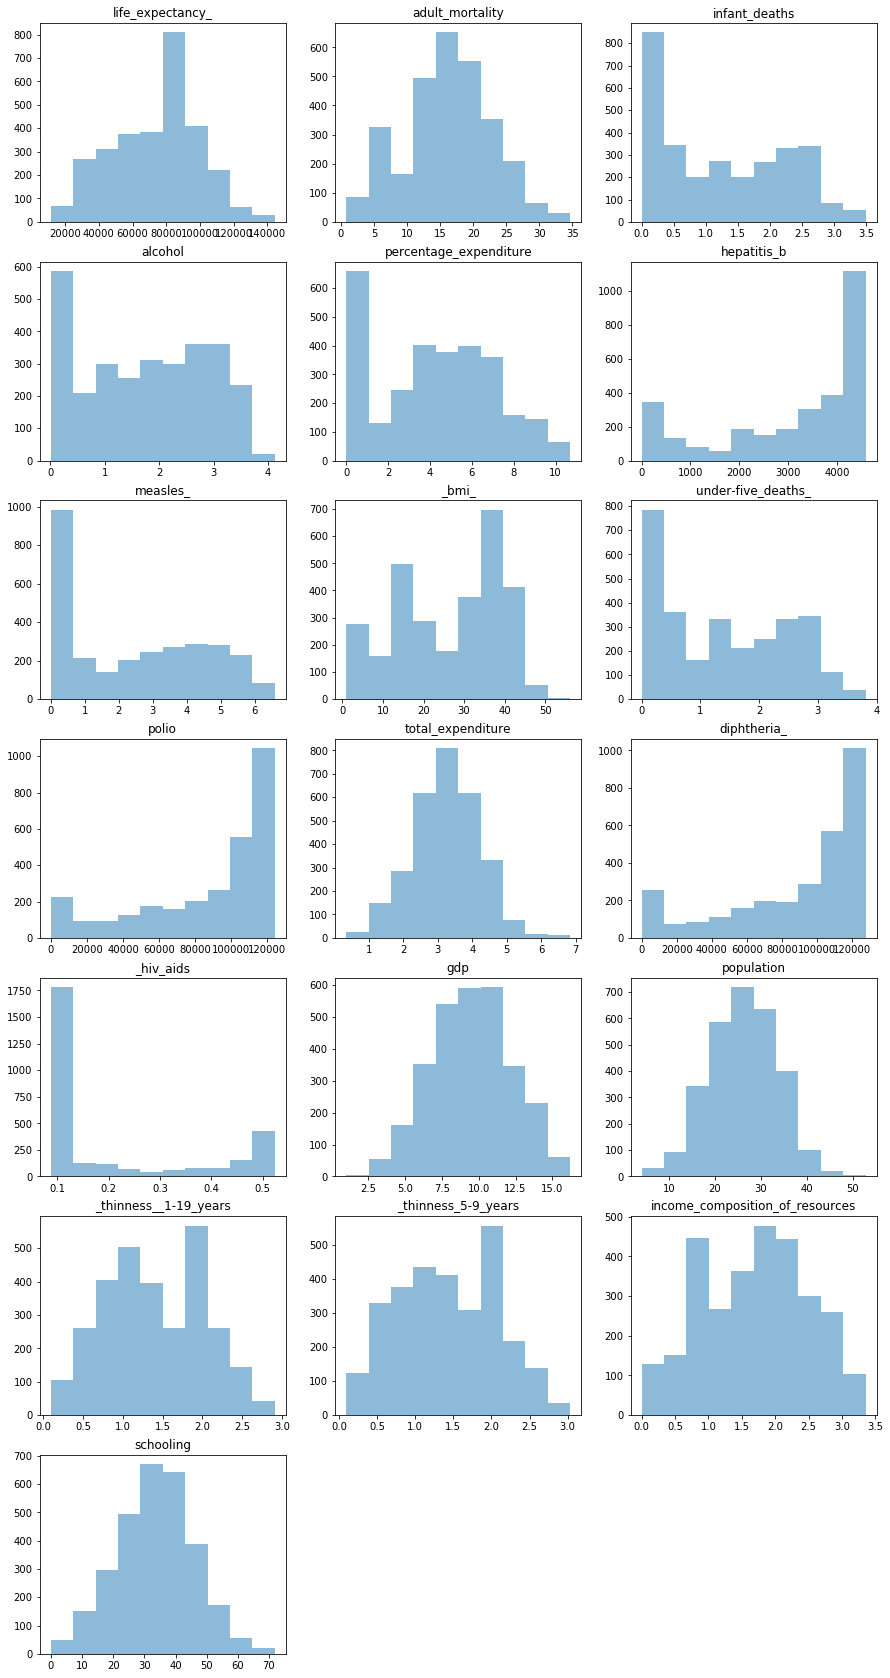

In [80]:
# show histogram for each column
# to show the distribution of the data
# to verify how much boxcox helped me

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

In [82]:
# examine correlation
# this seems to be about the same as before I did boxcox
life_exp.corr().iloc[:,1].sort_values(ascending=False)

life_expectancy_                   1.000000
income_composition_of_resources    0.786825
schooling                          0.734278
gdp                                0.579535
diphtheria_                        0.563323
polio                              0.555615
_bmi_                              0.543552
alcohol                            0.408287
percentage_expenditure             0.407320
hepatitis_b                        0.331980
total_expenditure                  0.228262
year                               0.163154
population                        -0.035532
measles_                          -0.283631
_thinness__1-19_years             -0.582172
adult_mortality                   -0.587406
_thinness_5-9_years               -0.590738
infant_deaths                     -0.598606
under-five_deaths_                -0.618545
_hiv_aids                         -0.772225
Name: life_expectancy_, dtype: float64

1. combine income composition of resources and percentage expenditure(maybe gdp?) into one feature
1. life expectancy scalled by the size of the country(normalize the country size first), then multiply these two.
1. combine ailments together, such as polio, diptheria, hepatitis, measels, hiv
1. 

In [83]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,59154.004607,21.966825,2.631244,0.009961,4.428511,2013.783904,4.839565,14.589876,2.870100,78.510304,4.145291,40303.753373,0.087144,7.583549,36.573937,2.562397,2.642781,0.946888,25.328623
1,Afghanistan,2014,Developing,46944.119751,22.270727,2.642828,0.009961,4.461230,1836.638852,4.440540,14.247530,2.883731,28787.746108,4.152151,35423.226678,0.087144,7.650197,21.635061,2.575072,2.651734,0.937201,24.971339
2,Afghanistan,2013,Developing,46944.119751,22.157385,2.653978,0.009961,4.456849,1953.839524,4.373918,13.904075,2.896804,34519.051561,4.134987,38632.067241,0.087144,7.693224,36.339393,2.583398,2.660584,0.918003,24.615772
3,Afghanistan,2012,Developing,46063.198635,22.308345,2.669952,0.009961,4.526195,2136.359304,5.213627,13.559479,2.913435,42644.475766,4.267695,43784.335547,0.087144,7.775964,28.776846,2.591627,2.673672,0.895902,24.261930
4,Afghanistan,2011,Developing,45409.632304,22.420719,2.680137,0.009961,2.126425,2198.989757,5.244933,13.282956,2.929230,44402.886790,4.044989,45594.297413,0.087144,4.664629,28.084246,2.603796,2.682276,0.867948,23.210830


In [16]:
# 1 option
# cap outlier columns at 80th percentile
# using winsorize

# for column in columns_with_outliers:
#     life_exp[column] = winsorize(life_exp[column], (0, 0.2))

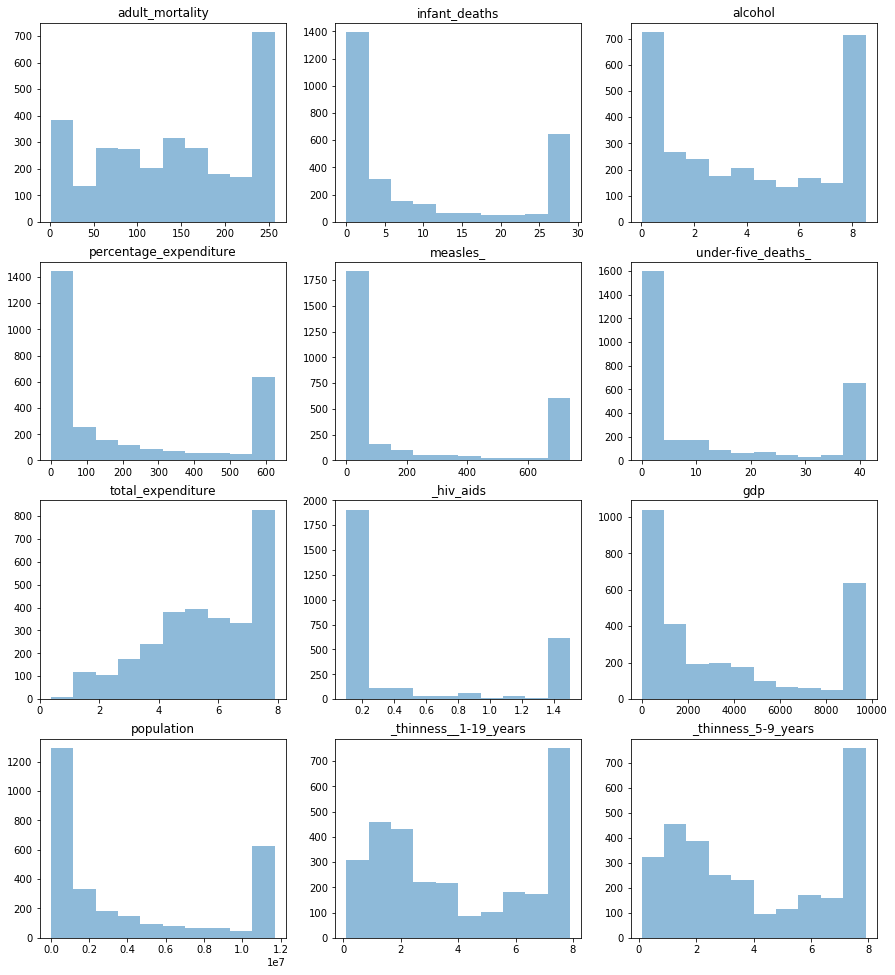

In [17]:
# compare against earlier histograms of outlier data
# the issues now is that the upper bound of each of  
# these has a whole bunch of observations because of the capping process

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(columns_with_outliers):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

Something to talk about with mentor, would it have been better to have taken the log transformation of the outlier columns?

### 2. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.


#### Univariate analysis

In [18]:
# descriptive staticts
life_exp.describe()

,year,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,144.072498,9.704561,4.078119,208.548822,76.029272,203.118108,38.29869,13.277740,82.307692,5.603822,82.075221,0.469197,3716.923117,4.069271e+06,4.094124,4.097873,0.634458,12.076804
std,4.613841,9.510819,84.464538,11.660321,3.226163,247.725938,28.359428,296.980200,19.99140,16.412181,23.636677,1.887178,23.917022,0.569172,3658.343194,4.562127e+06,2.765477,2.774606,0.209574,3.342316
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,66.000000,0.000000,19.32500,0.000000,77.000000,4.300000,78.000000,0.100000,542.227967,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.730000,93.000000,0.100000,2124.768139,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.437500,97.000000,0.800000,7077.188915,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,257.000000,29.000000,8.510000,623.910050,99.000000,741.000000,87.30000,41.000000,99.000000,7.900000,99.000000,1.500000,9707.286693,1.169586e+07,7.900000,7.900000,0.948000,20.700000


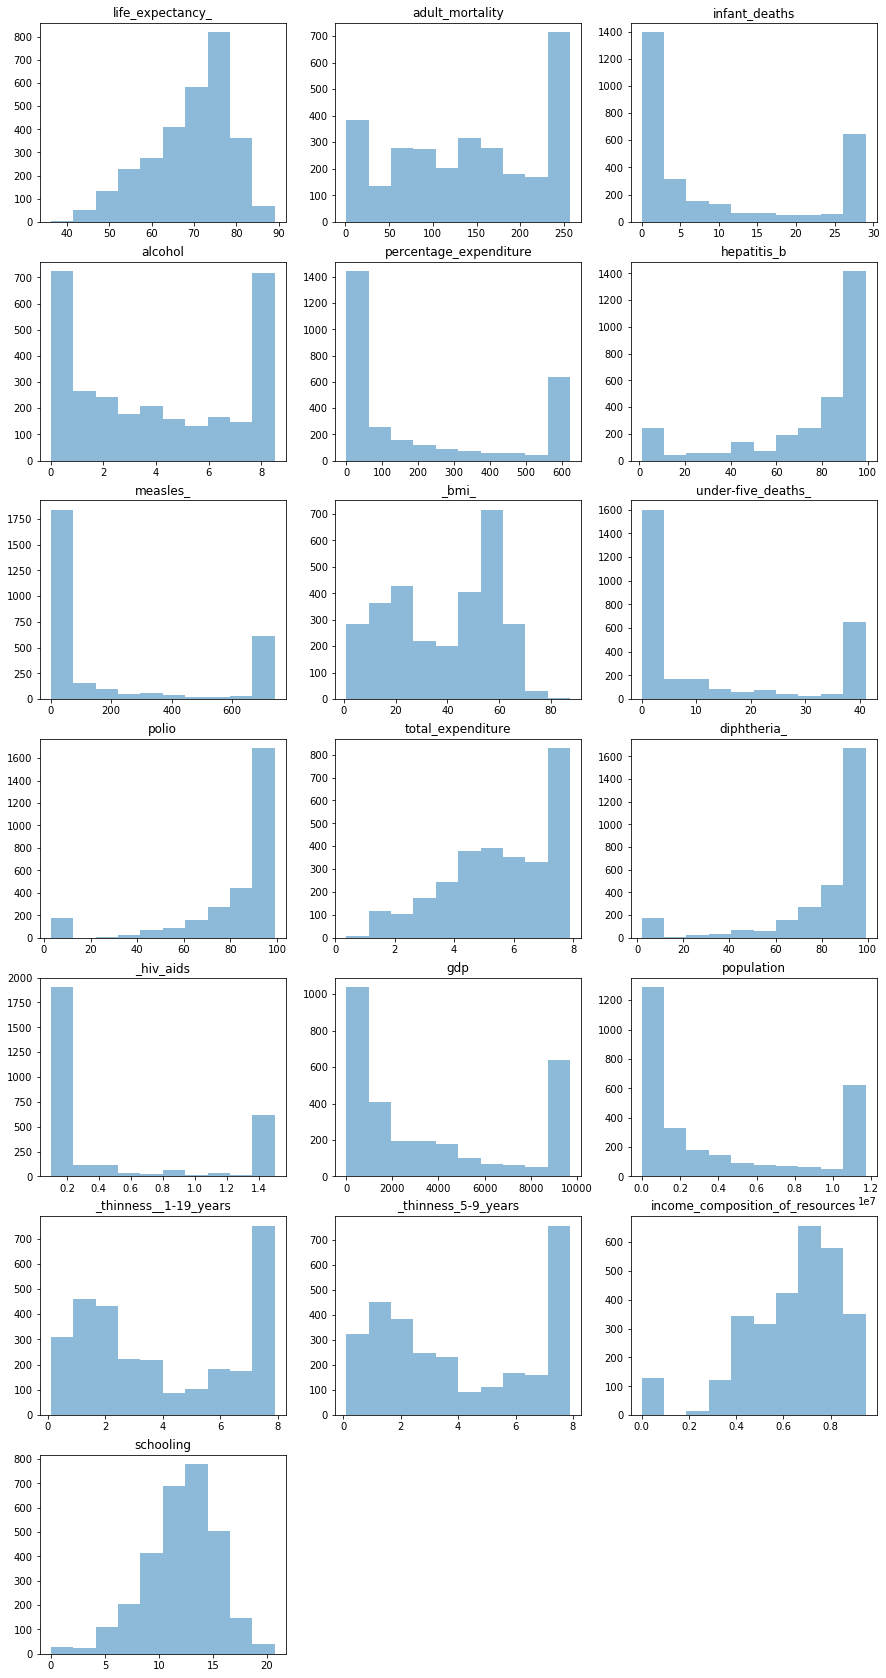

In [19]:
# show histogram for each column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

In [20]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,257.0,29,0.01,71.279624,65.0,741,19.1,41,6.0,7.90,65.0,0.1,584.259210,11695863.0,7.9,7.9,0.479,10.1
1,Afghanistan,2014,Developing,59.9,257.0,29,0.01,73.523582,62.0,492,18.6,41,58.0,7.90,62.0,0.1,612.696514,327582.0,7.9,7.9,0.476,10.0
2,Afghanistan,2013,Developing,59.9,257.0,29,0.01,73.219243,64.0,430,18.1,41,62.0,7.90,64.0,0.1,631.744976,11695863.0,7.9,7.9,0.470,9.9
3,Afghanistan,2012,Developing,59.5,257.0,29,0.01,78.184215,67.0,741,17.6,41,67.0,7.90,67.0,0.1,669.959000,3696958.0,7.9,7.9,0.463,9.8
4,Afghanistan,2011,Developing,59.2,257.0,29,0.01,7.097109,68.0,741,17.2,41,68.0,7.87,68.0,0.1,63.537231,2978599.0,7.9,7.9,0.454,9.5


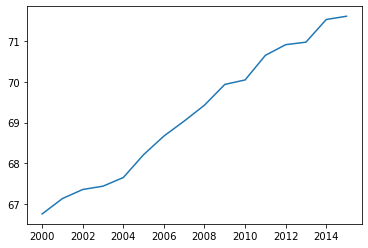

In [21]:
# plot life expectancy across time
# aggregated for all countries

x = life_exp[['year', 'life_expectancy_']].groupby('year').mean().index
y = life_exp[['year', 'life_expectancy_']].groupby('year').mean().iloc[:,0]

plt.plot(x, y);

Clearly, life expectancy has been going up over time.

In [49]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling,pca_1
0,Afghanistan,2015,Developing,59155.175264,75.642436,1.840654,0.009962,4.248299,2055.422296,2.690447,14.479759,2.010688,78.660518,18.493911,40518.257506,0.051529,13.784732,123.383745,2.773559,2.928229,0.985282,25.827119,1.046282
1,Afghanistan,2014,Developing,46945.027275,75.642436,1.840654,0.009962,4.281843,1874.082477,2.601859,14.141062,2.010688,28936.742290,18.493911,35609.216189,0.051529,13.978238,57.683557,2.773559,2.928229,0.974883,25.460247,1.046282
2,Afghanistan,2013,Developing,46945.027275,75.642436,1.840654,0.009962,4.277349,1994.052692,2.571742,13.801238,2.010688,34701.219046,18.493911,38836.765359,0.051529,14.104005,123.383745,2.773559,2.928229,0.954290,25.095179,1.046282
3,Afghanistan,2012,Developing,46064.087401,75.642436,1.840654,0.009962,4.348617,2180.929437,2.690447,13.460254,2.010688,42874.569887,18.493911,44019.378504,0.051529,14.347720,96.892643,2.773559,2.928229,0.930610,24.731923,1.046282
4,Afghanistan,2011,Developing,45410.507174,75.642436,1.840654,0.009962,2.006039,2245.066559,2.690447,13.186607,2.010688,44643.473143,18.393843,45840.082520,0.051529,6.733429,92.571025,2.773559,2.928229,0.900701,23.653102,1.046282


In [54]:
# which countries are associated with the highest life expectancy?
life_exp[['country','life_expectancy_']].groupby('country') \
    .mean().sort_values(by='life_expectancy_', ascending=False).head(10)

,life_expectancy_
country,
Sweden,116691.832424
Japan,116485.796781
Iceland,116298.883636
Switzerland,115703.733099
France,115614.865280
Italy,115367.450361
Spain,114923.766943
Norway,113856.774804
Australia,113679.064971


Many of these countries aren't especially wealthy, such as Spain, Iceland, or Australia.  The United States isn't even in the top 10.

In [55]:
# which countries are associated with the lowest life expectancy?
life_exp[['country','life_expectancy_']].groupby('country') \
    .mean().sort_values(by='life_expectancy_', ascending=True).head(10)

,life_expectancy_
country,
Sierra Leone,22859.745237
Central African Republic,26228.460975
Lesotho,26561.187526
Angola,26879.142953
Malawi,28815.375732
Côte d'Ivoire,28942.370817
Chad,28993.259427
Zimbabwe,30308.525835
Nigeria,30713.006479


Most of these countries are in Africa where where the largest contributors to death are probably AIDS and infant mortality.

#### Multivariate Analysis

In [39]:
# which of the attributes correlates most strongly with life_expectancy?
life_exp.corr().iloc[:,1].sort_values(ascending=False)

life_expectancy_                   1.000000
income_composition_of_resources    0.789755
schooling                          0.734399
diphtheria_                        0.563361
polio                              0.555656
gdp                                0.551050
_bmi_                              0.543260
alcohol                            0.396186
percentage_expenditure             0.350411
hepatitis_b                        0.332195
total_expenditure                  0.250836
year                               0.163154
population                        -0.032731
measles_                          -0.251101
adult_mortality                   -0.561896
infant_deaths                     -0.589802
under-five_deaths_                -0.604541
_thinness__1-19_years             -0.606586
_thinness_5-9_years               -0.617907
_hiv_aids                         -0.739883
pca_1                             -0.818150
Name: life_expectancy_, dtype: float64

Schooling appears to be the most highly correlated with life expectancy.

In [23]:
# which of the attributes correlates most negatively with life_expectancy?
life_exp.corr().iloc[:,1].sort_values()

_hiv_aids                         -0.794873
under-five_deaths_                -0.617385
_thinness_5-9_years               -0.600846
_thinness__1-19_years             -0.595754
infant_deaths                     -0.593818
adult_mortality                   -0.583888
measles_                          -0.336149
population                         0.000652
year                               0.168309
total_expenditure                  0.205823
hepatitis_b                        0.304380
alcohol                            0.388511
polio                              0.459201
diphtheria_                        0.473851
percentage_expenditure             0.481269
gdp                                0.506403
_bmi_                              0.556433
income_composition_of_resources    0.690071
schooling                          0.703409
life_expectancy_                   1.000000
Name: life_expectancy_, dtype: float64

HIV Aids appears to be most highly negatively correlated with life expectancy.

### 3.  In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

normalize population, then multiply by life expectancy

In [60]:
# scale life expectancy based on population
# what are alternative ways I can do this?

life_exp['life_exp_scale'] = life_exp.population + life_exp.life_expectancy_

<font color=green></font>

#### Dataset Attributes
1. <font color=red>Life expectancyLife Expectancy in age - this is the target variable</font>
1. Adult MortalityAdult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
1. infant deathsNumber of Infant Deaths per 1000 population
1. AlcoholAlcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
1. <font color=green>percentage expenditureExpenditure on health as a percentage of Gross Domestic Product per capita(%) - some countries may not be particularly efficient at producing positive outcomes through healthcare spending.</font>
1. Hepatitis BHepatitis B (HepB) immunization coverage among 1-year-olds (%)
1. MeaslesMeasles - number of reported cases per 1000 population
1. <font color=green>BMIAverage Body Mass Index of entire population - this could go either way, countries with more resources may be prone to higher bmi which could be linked to diseases that shorten life expectancy, such as heart disease.  On the other hand, people are struggling with famine, who can't get enough food may suffer life shortening consequences too.</font> 
1. <font color=green>under-five deathsNumber of under-five deaths per 1000 population - a higher number of these will pull the life expectancy down since deaths in this category represent such small numbers.</font>
1. PolioPolio (Pol3) immunization coverage among 1-year-olds (%)
1. Total expenditureGeneral government expenditure on health as a percentage of total government expenditure (%)
1. DiphtheriaDiphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
1. HIV/AIDSDeaths per 1 000 live births HIV/AIDS (0-4 years)
1. <font color=green>GDPGross Domestic Product per capita (in USD) - similar to BMI above, a country with a higher life expectancy will probably be a country with a medium level of financial resources.</font>
1. <font color=green>PopulationPopulation of the country - this could be usefull to scale countries statistics.  As it is each country is representing a similar weight with its statistics.  A country with a small population and low life expectancy should not carry the same weight as a much larger country with a low life expectancy</font>
1. thinness 1-19 yearsPrevalence of thinness among children and adolescents for Age 10 to 19 (% )
1. thinness 5-9 yearsPrevalence of thinness among children for Age 5 to 9(%)
1. Income composition of resourcesHuman Development Index in terms of income composition of resources (index ranging from 0 to 1)
1. <font color=green>SchoolingNumber of years of Schooling(years) - higher education is associated with higher earning power, which would be represented in higher gdp.  However more wealthy countries may struggle with issues like obesity.</font>

In [48]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling,pca_1
0,Afghanistan,2015,Developing,59155.175264,75.642436,1.840654,0.009962,4.248299,2055.422296,2.690447,14.479759,2.010688,78.660518,18.493911,40518.257506,0.051529,13.784732,123.383745,2.773559,2.928229,0.985282,25.827119,1.046282
1,Afghanistan,2014,Developing,46945.027275,75.642436,1.840654,0.009962,4.281843,1874.082477,2.601859,14.141062,2.010688,28936.742290,18.493911,35609.216189,0.051529,13.978238,57.683557,2.773559,2.928229,0.974883,25.460247,1.046282
2,Afghanistan,2013,Developing,46945.027275,75.642436,1.840654,0.009962,4.277349,1994.052692,2.571742,13.801238,2.010688,34701.219046,18.493911,38836.765359,0.051529,14.104005,123.383745,2.773559,2.928229,0.954290,25.095179,1.046282
3,Afghanistan,2012,Developing,46064.087401,75.642436,1.840654,0.009962,4.348617,2180.929437,2.690447,13.460254,2.010688,42874.569887,18.493911,44019.378504,0.051529,14.347720,96.892643,2.773559,2.928229,0.930610,24.731923,1.046282
4,Afghanistan,2011,Developing,45410.507174,75.642436,1.840654,0.009962,2.006039,2245.066559,2.690447,13.186607,2.010688,44643.473143,18.393843,45840.082520,0.051529,6.733429,92.571025,2.773559,2.928229,0.900701,23.653102,1.046282


In [40]:
life_exp.columns[3:]

Index(['life_expectancy_', 'adult_mortality', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'hepatitis_b', 'measles_', '_bmi_',
       'under-five_deaths_', 'polio', 'total_expenditure', 'diphtheria_',
       '_hiv_aids', 'gdp', 'population', '_thinness__1-19_years',
       '_thinness_5-9_years', 'income_composition_of_resources', 'schooling',
       'pca_1'],
      dtype='object')

In [37]:
# apply box cox to all variables
# but to be able to do this I need all variables to be positive

for column in life_exp.columns[3:]:
    life_exp[column],_ = boxcox(life_exp.loc[:,column] + 1)


ValueError: Data must be positive.

ValueError: Data must be positive.

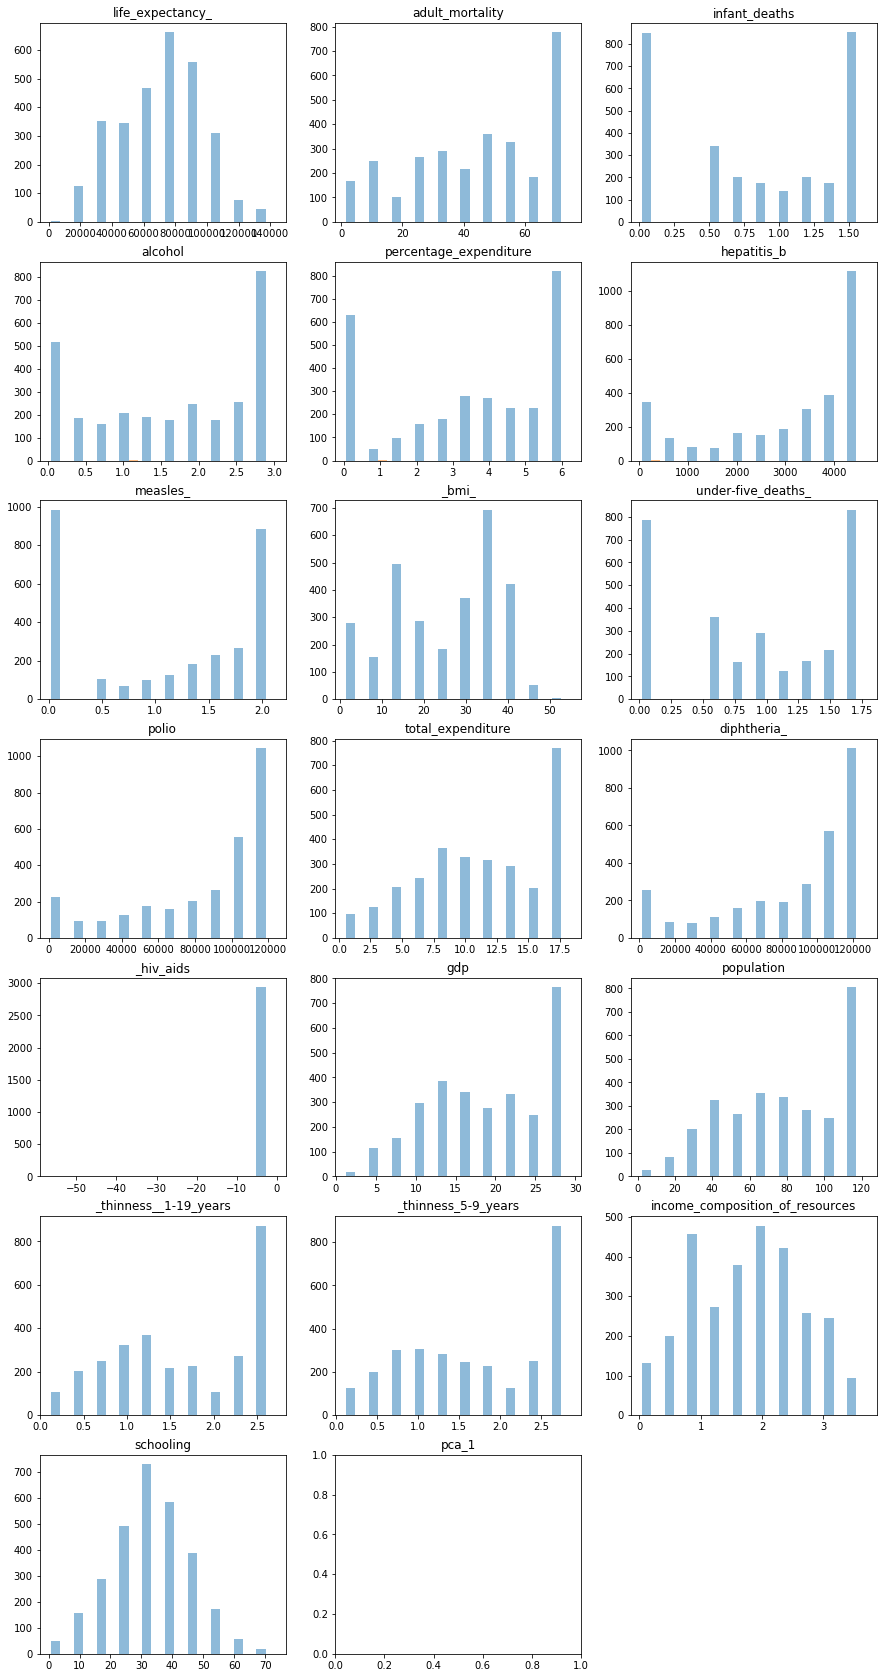

In [41]:
# show histogram for each column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(boxcox(life_exp[column] + 1), alpha=.5);

In [63]:
# which of the attributes correlates most strongly with life_expectancy?
# life_exp.corr().iloc[:,1].sort_values(ascending=False)
life_exp.corr().sort_values(ascending=False, by='life_expectancy_')

,year,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling,pca_1,life_exp_scale
life_expectancy_,0.163154,1.000000,-0.561896,-0.589802,0.396186,0.350411,0.332195,-0.251101,0.543260,-0.604541,0.555656,0.250836,0.563361,-0.739883,0.551050,-0.032731,-0.606586,-0.617907,0.789755,0.734399,-0.818150,0.999999
life_exp_scale,0.163190,0.999999,-0.561883,-0.589431,0.396178,0.350361,0.332188,-0.250807,0.543253,-0.604180,0.555649,0.250739,0.563362,-0.739868,0.551130,-0.031478,-0.606556,-0.617872,0.789833,0.734427,-0.817980,1.000000
income_composition_of_resources,0.193431,0.789755,-0.463439,-0.497348,0.467675,0.309505,0.287713,-0.150900,0.500133,-0.504997,0.499932,0.203993,0.489970,-0.592007,0.636022,0.037002,-0.535119,-0.538953,1.000000,0.872638,-0.675002,0.789833
schooling,0.177348,0.734399,-0.415143,-0.517630,0.491450,0.322239,0.298674,-0.209093,0.491667,-0.525627,0.492032,0.263605,0.484918,-0.568795,0.593273,-0.001163,-0.526207,-0.529237,0.872638,1.000000,-0.670480,0.734427
diphtheria_,0.153436,0.563361,-0.292874,-0.394483,0.261639,0.210626,0.670289,-0.235844,0.329568,-0.397036,0.852934,0.179215,1.000000,-0.452124,0.357702,-0.017678,-0.258111,-0.263013,0.489970,0.484918,-0.472217,0.563362
polio,0.120798,0.555656,-0.289277,-0.409595,0.262130,0.195523,0.615450,-0.234102,0.330176,-0.412156,1.000000,0.172038,0.852934,-0.464421,0.371356,-0.023074,-0.246940,-0.253973,0.499932,0.492032,-0.477466,0.555649
gdp,0.140656,0.551050,-0.304516,-0.429186,0.395242,0.397337,0.223621,-0.176084,0.385263,-0.433121,0.371356,0.125911,0.357702,-0.450887,1.000000,0.046161,-0.363456,-0.376886,0.636022,0.593273,-0.518396,0.551130
_bmi_,0.096211,0.543260,-0.335385,-0.443455,0.284196,0.230992,0.228113,-0.267056,1.000000,-0.454781,0.330176,0.220046,0.329568,-0.497234,0.385263,-0.022811,-0.534708,-0.547021,0.500133,0.491667,-0.619366,0.543253
alcohol,-0.085121,0.396186,-0.191160,-0.358247,1.000000,0.223464,0.111896,-0.206462,0.284196,-0.357356,0.262130,0.320199,0.261639,-0.188069,0.395242,-0.019107,-0.440679,-0.434852,0.467675,0.491450,-0.400830,0.396178
percentage_expenditure,-0.074018,0.350411,-0.243665,-0.320049,0.223464,1.000000,0.105472,-0.140273,0.230992,-0.321112,0.195523,0.108508,0.210626,-0.213024,0.397337,-0.050893,-0.241648,-0.244824,0.309505,0.322239,-0.321455,0.350361


PCA with positively correlated variables.

In [28]:
# use principal component analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select 3 features that I think are most correlated with life expectancy
X = StandardScaler().fit_transform(life_exp[['schooling', 
                                           'income_composition_of_resources', 
                                           '_bmi_']])
sklearn_pca = PCA(n_components=1)

# what is happening by the creation of this new column?
life_exp["pca_1"] = sklearn_pca.fit_transform(X)

# ratio of total variance in the dataset explained 
# by each component from PCA sklearn
sklearn_pca.explained_variance_ratio_

array([0.75340887])

The total variance in the dataset explained using PCA doesn't seem to be very high.

In [42]:
# which of the attributes correlates most strongly with life_expectancy?
life_exp.corr().iloc[:,1].sort_values(ascending=False)

life_expectancy_                   1.000000
income_composition_of_resources    0.789755
schooling                          0.734399
diphtheria_                        0.563361
polio                              0.555656
gdp                                0.551050
_bmi_                              0.543260
alcohol                            0.396186
percentage_expenditure             0.350411
hepatitis_b                        0.332195
total_expenditure                  0.250836
year                               0.163154
population                        -0.032731
measles_                          -0.251101
adult_mortality                   -0.561896
infant_deaths                     -0.589802
under-five_deaths_                -0.604541
_thinness__1-19_years             -0.606586
_thinness_5-9_years               -0.617907
_hiv_aids                         -0.739883
pca_1                             -0.818150
Name: life_expectancy_, dtype: float64

In [30]:
life_exp[['life_expectancy_',
        'pca_1',
        'schooling', 
        'income_composition_of_resources', 
        '_bmi_']].corr()

,life_expectancy_,pca_1,schooling,income_composition_of_resources,_bmi_
life_expectancy_,1.000000,-0.800992,0.734278,0.786825,0.543552
pca_1,-0.800992,1.000000,-0.927581,-0.930307,-0.730991
schooling,0.734278,-0.927581,1.000000,0.870052,0.491861
income_composition_of_resources,0.786825,-0.930307,0.870052,1.000000,0.499806
_bmi_,0.543552,-0.730991,0.491861,0.499806,1.000000


I'm confused why life expectancy(my target variable) is negatively correlated with the aggregate of my principle components.  But each of the attributes on their own are positively correlated.

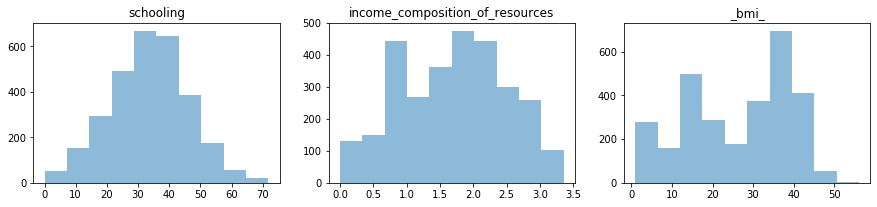

In [31]:
# show histogram for each column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 10))

for i, column in enumerate(life_exp[['schooling', 
                                    'income_composition_of_resources', 
                                    '_bmi_']]):

    plt.subplot(3, 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

At least 2 of the three variables don't seem to have a normal distribution.

PCA with negatively correlated variables.

In [32]:
# use principal component analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select 3 features that I think are most negatively correlated with life expectancy
X = StandardScaler().fit_transform(life_exp[['_hiv_aids', 
                                           'under-five_deaths_', 
                                           '_thinness_5-9_years']])
sklearn_pca = PCA(n_components=1)

# what is happening by the creation of this new column?
life_exp["pca_1"] = sklearn_pca.fit_transform(X)

# ratio of total variance in the dataset explained 
# by each component from PCA sklearn
sklearn_pca.explained_variance_ratio_

array([0.66271184])

The total variance in the dataset explained using PCA doesn't seem to be very high.

In [33]:
# which of the attributes correlates most strongly with life_expectancy?
life_exp.corr().iloc[:,1].sort_values()

pca_1                             -0.818150
_hiv_aids                         -0.759679
_thinness_5-9_years               -0.619128
under-five_deaths_                -0.618378
_thinness__1-19_years             -0.608293
infant_deaths                     -0.601287
adult_mortality                   -0.562770
measles_                          -0.275712
population                        -0.032310
year                               0.163154
total_expenditure                  0.250185
hepatitis_b                        0.331980
percentage_expenditure             0.382826
alcohol                            0.401839
_bmi_                              0.543552
gdp                                0.551461
polio                              0.555615
diphtheria_                        0.563323
schooling                          0.734278
income_composition_of_resources    0.786825
life_expectancy_                   1.000000
Name: life_expectancy_, dtype: float64

In [34]:
life_exp[['life_expectancy_',
        'pca_1',
        '_hiv_aids', 
       'under-five_deaths_', 
       '_thinness_5-9_years']].corr()

,life_expectancy_,pca_1,_hiv_aids,under-five_deaths_,_thinness_5-9_years
life_expectancy_,1.000000,-0.818150,-0.759679,-0.618378,-0.619128
pca_1,-0.818150,1.000000,0.819646,0.816545,0.805959
_hiv_aids,-0.759679,0.819646,1.000000,0.508624,0.489612
under-five_deaths_,-0.618378,0.816545,0.508624,1.000000,0.483853
_thinness_5-9_years,-0.619128,0.805959,0.489612,0.483853,1.000000


When I flip things around and find attributes that are most negatively correlated, PCA1 is more negatively correlated with life expectancy than the other three most negatively correlated attributes.

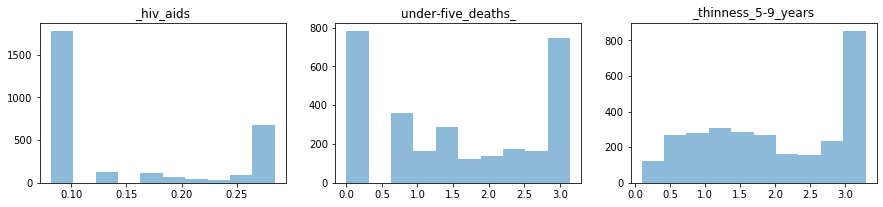

In [35]:
# show histogram for each column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 10))

for i, column in enumerate(life_exp[['_hiv_aids', 
                                    'under-five_deaths_', 
                                    '_thinness_5-9_years']]):

    plt.subplot(3, 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

None of these variables seem to have normal distributions.


### 4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.


time series analysis showing life expectancy trending over time as well as other attributes trending over time.

bar charts


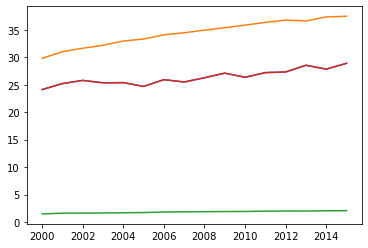

In [47]:
# plot life expectancy across time
# along with other attributes that are correlated with it

x = life_exp[['year', 'life_expectancy_']].groupby('year').mean().index
# y = life_exp[['year', 'life_expectancy_']].groupby('year').mean().iloc[:,0]

plt.plot(x, y)

y = life_exp[['year', 'schooling']].groupby('year').mean().iloc[:,0]

plt.plot(x, y)

y = life_exp[['year', 'income_composition_of_resources']].groupby('year').mean().iloc[:,0]

plt.plot(x, y)

y = life_exp[['year', '_bmi_']].groupby('year').mean().iloc[:,0]

plt.plot(x, y)



# life_exp[['schooling', 
#                                     'income_composition_of_resources', 
#                                     '_bmi_']]

add scatterplot to compare multiple continous variables

(21.0, 0.0)

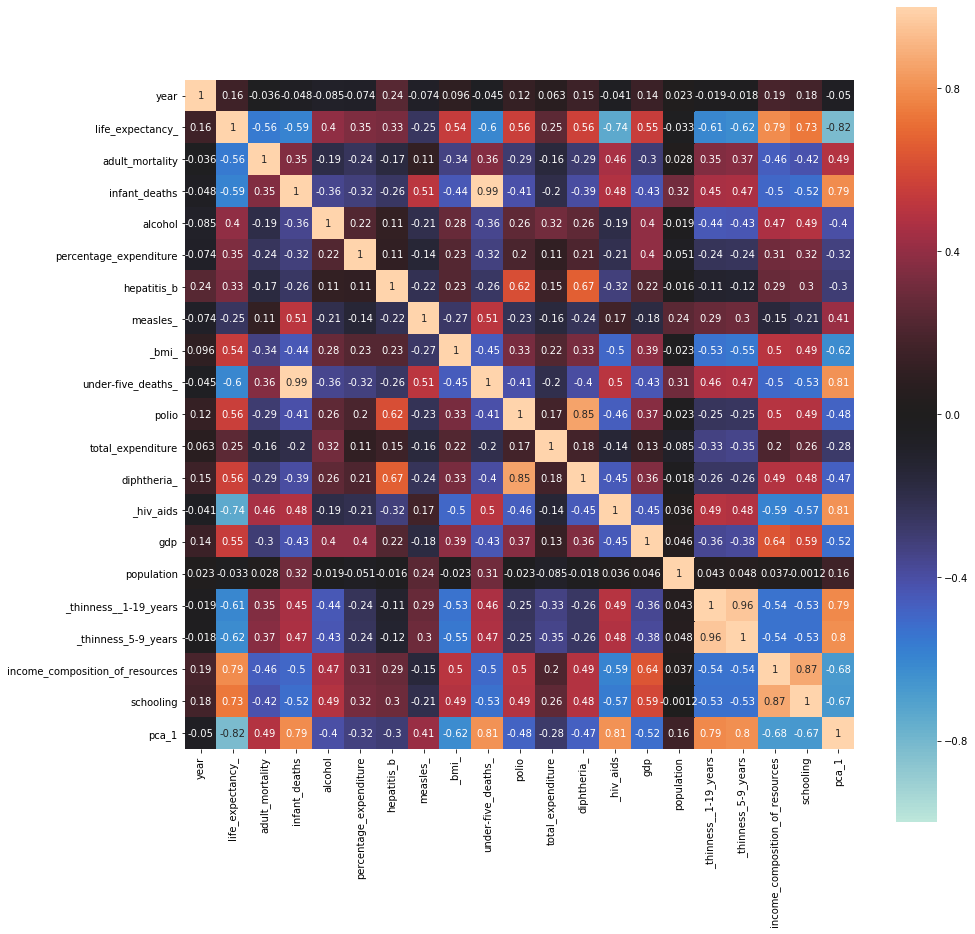

In [45]:

plt.figure(figsize=(15, 15))

ax = sns.heatmap(life_exp.corr(), vmin=-1, vmax=1, center=0, square=True, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)